# IEEE-CIS Fraud Detection

## Business Understanding

Imagine standing at the check-out counter at the grocery store with a long line behind you and the cashier not-so-quietly announces that your card has been declined. In this moment, you probably aren’t thinking about the data science that determined your fate.

Embarrassed, and certain you have the funds to cover everything needed for an epic nacho party for 50 of your closest friends, you try your card again. Same result. As you step aside and allow the cashier to tend to the next customer, you receive a text message from your bank. “Press 1 if you really tried to spend $500 on cheddar cheese.”

While perhaps cumbersome (and often embarrassing) in the moment, this fraud prevention system is actually saving consumers millions of dollars per year. Researchers from the IEEE Computational Intelligence Society (IEEE-CIS) want to improve this figure, while also improving the customer experience. With higher accuracy fraud detection, you can get on with your chips without the hassle.

IEEE-CIS works across a variety of AI and machine learning areas, including deep neural networks, fuzzy systems, evolutionary computation, and swarm intelligence. Today they’re partnering with the world’s leading payment service company, Vesta Corporation, seeking the best solutions for fraud prevention industry, and now you are invited to join the challenge.

In this competition, you’ll benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. You also have the opportunity to create new features to improve your results.

If successful, you’ll improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.

In [2]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import base
import pickle
import re
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
import lightgbm as lgb


In [ ]:
## Read files in
train_identity = pd.read_csv('train_identity.csv')
train_transactions = pd.read_csv('train_transaction.csv',dtype={'TransactionAmt': object})
test_identity = pd.read_csv('test_identity.csv')
test_transactions = pd.read_csv('test_transaction.csv',dtype={'TransactionAmt': object})

## Left joining transactions to identity for train and test
train_df = pd.merge(train_transactions,train_identity, how = 'left', on = "TransactionID")
test_df = pd.merge(test_transactions,test_identity, how = 'left', on = "TransactionID")

In [ ]:
train_df['train_data'] = 1
test_df['train_data'] =0
test_df['isFraud'] = 0

In [ ]:
df = pd.concat([train_df,test_df],sort =True)

In [ ]:
df.to_pickle('df.pickle')

In [ ]:
df= pd.read_pickle('df.pickle')

## Data Understanding


Lynn@Vesta provided some additional background of some of the information

https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-614363

#### Transaction Table
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

###### Categorical Features:
* ProductCD
* card1 - card6
* addr1, addr2
        addr1 as billing region
        addr2 as billing country
* Pemaildomain Remaildomain
* M1 - M9

#### Identity Table *
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

##### Categorical Features:
* DeviceType
* DeviceInfo
* id12 - id38


id01 to id11 are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc.

#### High Level Attribute Overview

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.describe(include = 'all')

In [ ]:
## NULL values as a percentage for each column.

null_df = df.isna().sum() /df.shape[0]
null_df[null_df >0]

## Attribute Analysis

In [ ]:
## Create a list for the V features
V_columns = []
for each in range(1,340):
    V_columns.append("V" + str(each))

## Create a list for the M features
M_columns = []
for each in range(1,10):
    M_columns.append("M" + str(each))

## Create a list for the C features
C_columns = []
for each in range(1,10):
    C_columns.append("C" + str(each))

In [ ]:
## Create some features that count the number of nulls in the rows before we replace them later

df['Total_Nulls'] = df.isnull().sum(axis=1)
df['V_Nulls'] = df[V_columns].isnull().sum(axis=1)
df['M_Nulls'] = df[M_columns].isnull().sum(axis=1)
df['C_Nulls'] = df[C_columns].isnull().sum(axis=1)
df['Card_Nulls'] = df[['card1','card2','card3','card4','card4','card5','card6']].isnull().sum(axis=1)

### Card1-6

Categorical Features with information such as payment card information, such as card type, card category, issue bank, country, etc.


For card2 we can replace it with the mode for the grouped value in card1

In [ ]:
for each in ['card1','card2','card3','card4','card5','card6']:
    print(each, "- NULLs: ",df[each].isna().sum())

In [ ]:
df['card2'].isna().sum()

#### Card3

In [ ]:
df['card3'].isna().sum()

#### Card4

In [ ]:
sns.countplot(x="card4", data=df)

#### Card6

In [ ]:
sns.countplot(x="card6", data=df)

In [ ]:
## Handling null Values in card 1-6
for each in ['card1','card2','card3','card5']:
    df[each].fillna(0, inplace= True)

for each in ['card4','card6']:
    df[each].fillna('Unknown', inplace= True)

In [ ]:
### Create unique ID's
df['card1_card2'] = df['card1'].astype(str)+'_'+df['card2'].astype(str)
df['card_1_card2_card3_card4'] = df['card1_card2'].astype(str)+'_'+df['card3'].astype(str)+'_'+df['card5'].astype(str)
df['card_1_card2_card3_card4_addr1_addr2'] = df['card_1_card2_card3_card4'].astype(str)+'_'+df['addr1'].astype(str)+'_'+df['addr2'].astype(str)

#### ProductCD

In [ ]:
df['ProductCD'].isna().sum()

In [ ]:
sns.countplot(x="ProductCD", data=df)

#### addr1, addr2, dist1, dist2

These columns have a couple of nulls in them. For addr1 and addr2, we will fill the na with 0 since these are categorical variables.

For dist1, dist2, we will instead use the mean since these are numeric

In [ ]:
### Replace na with 0 for addr1 and addr2
df['addr1'].fillna(value =0, inplace=True)
df['addr2'].fillna(value =0, inplace=True)

In [ ]:
### Replace na with mean for dist1 and dist2
df['dist1'].fillna(value = df['dist1'].mean(),inplace= True)
df['dist2'].fillna(value = df['dist2'].mean(),inplace= True)

#### P_emaildomain and R_emaildomain

These attributes correspond to the purcharsers email and the recipients email

In [ ]:
### Lets fill the nas with a category called None.None
df['P_emaildomain'].fillna(value = 'None.None', inplace = True)
df['R_emaildomain'].fillna(value = 'None.None', inplace = True)

In [ ]:
### Split the email domain into two based on the period, which will allow for groping the Yahoo's together etc
new = df['P_emaildomain'].str.split('.',n=1,expand=True)
df['P_domain_first_str'] = new[0]
df['P_domain_last_str'] = new[1]
df['P_domain_last_str'].fillna(value = 'None', inplace=True)

In [ ]:
new = df['R_emaildomain'].str.split('.',n=1,expand=True)
df['R_domain_first_str'] = new[0]
df['R_domain_last_str'] = new[1]
df['R_domain_last_str'].fillna(value = 'None', inplace=True)

In [ ]:
df['Same_Email'] = np.where(df['P_emaildomain'] == df['R_emaildomain'],1,0)

#### M1-M9
Match, such as names on card and address, etc.v

In [ ]:
for each in ['M1','M2','M3','M4','M5','M6','M7','M8','M9']:
    print(each,"is missing",df[each].isna().sum(), "attributes")

In [ ]:
sns.countplot(x="M3", data=df)

In [ ]:
### Filling each of the M values (except M4) with the false value with the assumptions that the company would capture true matches better
for each in ['M1','M2','M3','M5','M6','M7','M8','M9']:
    #df[each].fillna(value = 'F', inplace= True)  #maybe the nulls are important. Trying something new belo
    df[each].fillna(value = 'M', inplace= True)

In [ ]:
sns.countplot(x="M4", data=df)

In [ ]:
#replacing M4 nulls with the mode of M0
df['M4'].fillna(value = 'M0',inplace= True)

#### Device type and Info

In [ ]:
df['id_33'].describe()

In [ ]:
df['DeviceType'].isna().sum()

In [ ]:
sns.countplot(x="DeviceType", data=df)

In [ ]:
for each in ['id_12','id_15','id_16','id_23','id_27','id_28', 'id_29','id_34',
             'id_35','id_35','id_36','id_37','id_38']:
    df[each].fillna(value = 'Unknown', inplace = True)

In [ ]:
for each in ['id_13','id_14','id_17','id_18','id_19','id_20','id_21','id_22','id_24','id_25','id_26','id_32']:
    df[each].fillna(value = -1, inplace = True)

In [ ]:
## For id_33 which seems to be screen resolution, we will make it zeroxzero
df['id_33'].fillna("0x0",inplace =True)

#### C1-C14 
counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

In [ ]:
### Filling each of the C values with 0 because absense of value is most likely because of zeros
## changing data type to int as well
for each in ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']:
    df[each].fillna(value = 0, inplace= True)
    df[each]= df[each].astype('int')

#### D1-D15
 timedelta, such as days between previous transaction, etc

In [ ]:
### https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt

import datetime

START_DATE = '2018-01-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df["Date"] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df['_Weekdays'] = df['Date'].dt.dayofweek
df['_Hours'] = df['Date'].dt.hour
df['_Days'] = df['Date'].dt.day
df['_Month'] = df['Date'].dt.month
df['_Minute'] = df['Date'].dt.minute

In [ ]:
### replace all D1-D12 with 9999
for each in ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D9','D10','D11','D12','D13','D14','D15']:
    df[each].fillna(value = 9999, inplace = True)

#### ID_01 - ID_11

https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-614363

“id01 to id11 are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc. All of these are not able to elaborate due to security partner T&C. I hope you could get basic meaning of these features, and by mentioning them as numerical/categorical, you won't deal with them inappropriately.”

In [ ]:
### Replace all null values in the id_01-id_11 columns with 999 since there may be importance to their missingness
for each in ['id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10','id_11']:
    df[each].fillna(-9999, inplace= True)

In [ ]:
## Replace all null values in the V1-125 as the median
for each in range(1,340):
    a = ("V" + str(each))
    df[a].fillna(value = df[a].median(), inplace =True)

### Feature Engineering


In [ ]:

for each in ['DeviceType','DeviceInfo','id_30','id_31']:
    df[each].fillna('Unknown', inplace =True)

##### Transaction Amount

In [ ]:
### We read in transaction amount as a string to get the number of decimals. Store the original string as a new variable and
### make the original one a float
df['TransactionAmt_decimal_length'] = df['TransactionAmt']
df['TransactionAmt'] = df['TransactionAmt'].astype('float')

### Log transform transaction amount
df['TransactionAmt_Log'] = np.log1p(df['TransactionAmt'])

## Extract the length of the decimals from tranasction amount
df['TransactionAmt_decimal_length'] = df['TransactionAmt_decimal_length'].str.split('.', expand= True)[1]
df['TransactionAmt_decimal_length'] = df['TransactionAmt_decimal_length'].apply(len)

# https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm-corrected/output

# New feature - decimal part of the transaction amount.
df['TransactionAmt_decimal'] = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).astype(int)

In [ ]:
### Create mean std by some of the card features and other unique id's we identified
list_of_columns = ['card1','card1_card2','card_1_card2_card3_card4','card_1_card2_card3_card4_addr1_addr2','card2','card3','card4','id_02','D15','ProductCD']
#df['key'] = df[each].astype(str) +'_'+ df['TransactionAmt'].astype(str)

for each in list_of_columns:
    df[each+'_trx_amt_mean'] = df.groupby(each)['TransactionAmt'].transform('mean')
    df[each+'_trx_amt_std'] =  df.groupby(each)['TransactionAmt'].transform('std')
### Create a count of number of transaction by unique ID and transaction amount
    #df[each+'_trx_amt_ctd'] = df.groupby('key')['C1'].transform('count')

#df.drop('key', axis = 1)

In [ ]:
null_df = df.isna().sum() /df.shape[0]
null_df[null_df >0]

In [ ]:
### Some of the std columns have nulls. fill them with global std of transaction amount
std_columns = ['card1_trx_amt_std', 'card1_card2_trx_amt_std', 'card_1_card2_card3_card4_trx_amt_std'
              , 'card_1_card2_card3_card4_addr1_addr2_trx_amt_std','card3_trx_amt_std', 'id_02_trx_amt_std', 'D15_trx_amt_std']
for each in std_columns:
    df[each].fillna(np.std(df['TransactionAmt']), inplace =True)

In [ ]:
df['Trx_Amt_Delta_ProdCD'] = (df['TransactionAmt']-df['ProductCD_trx_amt_mean'])/ df['ProductCD_trx_amt_std']
df['Trx_Amt_Delta_card1'] = (df['TransactionAmt']-df['card1_trx_amt_mean'])/ df['card1_trx_amt_std']
df['Trx_Amt_Delta_card_1_card2_card3_card4'] = (df['TransactionAmt']-df['card_1_card2_card3_card4_trx_amt_mean'])/ df['card_1_card2_card3_card4_trx_amt_std']
df['Trx_Amt_Delta_id_02'] = (df['TransactionAmt']-df['id_02_trx_amt_mean'])/ df['id_02_trx_amt_std']

In [ ]:
### Fill the rest of the columns with the mean
for each in null_df[null_df >0].index:
    df[each].fillna(df[each].mean, inplace =True)

In [ ]:
null_df = df.isna().sum() /df.shape[0]
null_df[null_df >0]

In [ ]:
### Columns to drop

columns_to_drop = ['card1_card2','card_1_card2_card3_card4','card_1_card2_card3_card4_addr1_addr2']
df= df.drop(columns_to_drop, axis = 1)

In [ ]:
## ## list of attributes we will target and frequency encode
target_encoded_list = []
for each in df.columns:
    if df[each].dtype == 'object':
        target_encoded_list.append(each)

In [ ]:
## Frequency encoding
#https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again

for col in target_encoded_list:
    print(col)
#     temp_df = pd.concat([df[[col]], df[[col]]])
    fq_encode = df[col].value_counts(dropna=False).to_dict()   
    df[col+'_fq_enc'] = df[col].map(fq_encode)

In [ ]:
df.to_pickle('df6.pickle')

## Train, Validation and Test Splitting

It looks like the train testing split is based on transaction data and as such we will split our training data based on time.

In [ ]:
df= pd.read_pickle('df6.pickle')

In [ ]:
X_train = df[(df['train_data']==1)]


In [ ]:
X_test = df[(df['train_data']==0)]

## Target Encoding

### Why do we target encode? 

Gradient boosted tree-based models such as XGBoost and LightGBM have a hard time handling high cardinality categorical variables. Target Encoding helps with that and can help improve the model performance. 

### Why do we need to reguralize?

Simply calculating the averages of the target variables can cause overfitting and often reduces the models ability to be generalized. 

#### Regularization Techniques:

 - Cross Validation Loop inside training data
 - Smoothing
 - Adding Random Noise
 - Sorting and Calculating expanding mean

We will only do cross-validation Loop inside our training data. To get started, we will define two helper function that I picked up from https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b



In [ ]:
## Helper Function to KFold Mean encoding
class KFoldTargetEncoderTrain(base.BaseEstimator,
                               base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = False, random_state=2019)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName,                    
                   np.corrcoef(X[self.targetName].values,
                               encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X

    
## Helper function to get the Kfold Mean encoded on the test set

class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        mean =  self.train[[self.colNames,
                self.encodedName]].groupby(
                                self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})
        return X

In [ ]:
### For some of the variables we need to encode, they have zero as the value and their kfold score would also be zero
#### This confuses the replace function, so we need to adjust them before
for each in target_encoded_list:
    #X_valid.loc[X_valid[each] == 0.0, each] = -999
    X_train.loc[X_train[each] == 0.0, each] = -999
    X_test.loc[X_test[each] == 0.0, each] = -999


In [ ]:
### Loops through the target list
for each in target_encoded_list:
    targetc = KFoldTargetEncoderTrain(each,'isFraud',n_fold=3)
    X_train = targetc.fit_transform(X_train)
    a_name = (str(each)+"_Kfold_Target_Enc")
    test_targetc = KFoldTargetEncoderTest(X_train,each,a_name)
    #X_valid = test_targetc.fit_transform(X_valid)
    X_test = test_targetc.fit_transform(X_test)


## Trouble Columns... NEED SOME WORK

In [21]:
## Some columns had unseeen values. Since we wouldn't know what their mean was, we simply need to apply the global target mean from our train set


problem_columns = ['P_domain_first_str_Kfold_Target_Enc', 'P_domain_last_str_Kfold_Target_Enc', 'P_emaildomain_Kfold_Target_Enc','id_30_Kfold_Target_Enc'
                   , 'id_31_Kfold_Target_Enc', 'id_33_Kfold_Target_Enc', 'DeviceInfo_Kfold_Target_Enc'
                   , 'DeviceInfo_Kfold_Target_Enc']

In [ ]:
y= X_train['isFraud']

In [ ]:
for each in X_train.columns:
    print(X_train[each].dtype)

In [ ]:
### Drop all object columns
object_columns = []
for each in X_train.columns:
    if X_train[each].dtype == 'object':
        object_columns.append(each)

X_train= X_train.drop(object_columns, axis = 1)
X_test= X_test.drop(object_columns, axis = 1)


In [22]:

for each in problem_columns:
    X_test[each] = pd.to_numeric(X_test[each],errors = 'coerce')
    X_test[each].fillna(np.mean(y), inplace =True)

## Machine Learning Goal

Correctly classify transactions as fraud or not fraud for unlabelled data in the test set. Evaluation metric is AUC

## Modeling

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.
- For more details, please refer to Features.


LightGBM really good at handling datasets larger than 100K records, and does so realatively fast compared to XGBoost. 

https://lightgbm.readthedocs.io/en/latest/

Like most boosted models, we will need to tune our hyper-paremeters. These are the ones that I had the most success with, but it does not mean that they are the "ultimate" ones.

Generally speaking, I follow the guidance of the documentations:

LightGBM uses the leaf-wise tree growth algorithm, while many other popular tools use depth-wise tree growth. Compared with depth-wise growth, the leaf-wise algorithm can converge much faster. However, the leaf-wise growth may be over-fitting if not used with the appropriate parameters.

To get good results using a leaf-wise tree, these are some important parameters:

__num_leaves.__ This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.

__min_data_in_leaf.__ This is a very important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
max_depth. You also can use max_depth to limit the tree depth explicitly.

In [ ]:
X_train.to_pickle('X_train_lgb_crs_val.pickle')
X_test.to_pickle('X_test_lgb_crs_val.pickle')
y.to_pickle('ytrain.pickle')
#test_id_to_be_used.to_pickle('test_id.pickle')

In [ ]:
X_train = pd.read_pickle('X_train_lgb_crs_val.pickle')
X_test = pd.read_pickle('X_test_lgb_crs_val.pickle')
y = pd.read_pickle('ytrain.pickle')

In [ ]:
## Drop some columns not needed for modeling
Drop_em = ['TransactionAmt','TransactionDT','TransactionID','Date', 'isFraud']
#Drop_em = ['isFraud']
X_train= X_train.drop(Drop_em, axis = 1)
X_test= X_test.drop(Drop_em, axis = 1)

In [ ]:
for each in X_train.columns:
    print(each)

### HYPER PARAMETER TUNING

In [ ]:
gridParams = {
    'learning_rate': [0.01],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'metric': ['auc'],
    'subsample_freq': [1],
    'num_leaves': [2**8],
    'max_depth':[-1],
    'tree_learner':['serial'],
    'colsample_bytree': [0.8,0.9,1],
    'subsample':[0.8,0.9,1],
    'n_estimators':[20000],
     'max_bin':[255,500],
     'verbose':[10],
   'reg_alpha' : [1,1.2,5],
    'reg_lambda' : [1,1.2,5]
    }

In [ ]:
clf = lgb.LGBMClassifier()
grid = RandomizedSearchCV(clf,gridParams,verbose=20,cv=3,n_jobs = 1,n_iter=5)
grid.fit(X_train,y)

### SIMPLE LGB MODEL WITH ONE MONTHS VALIDATION

In [3]:
X_train= pd.read_pickle('X_train_lgb_crs_val.pickle')
X_test = pd.read_pickle('X_test_lgb_crs_val.pickle')

In [4]:
### Use the last month for validation
### https://www.kaggle.com/kyakovlev/ieee-cv-options
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_valid = X_train[X_train['DT_M']==X_train['DT_M'].max()].reset_index(drop=True)
X_train = X_train[X_train['DT_M']<(X_train['DT_M'].max())].reset_index(drop=True)
# X_test = X_test.drop(['DT_M'], axis = 1)


In [5]:
y= X_train['isFraud']
Y_valid =X_valid['isFraud']
test_id_to_be_used =X_test['TransactionID']

## Drop Categorical Variables that we mean encoded, the target and the item codes.
columns_to_drop = ['TransactionAmt','TransactionDT','isFraud','Date', 'TransactionID']
X_train= X_train.drop(columns_to_drop, axis = 1)
X_valid = X_valid.drop(columns_to_drop, axis = 1)
X_test = X_test.drop(columns_to_drop, axis = 1)


### Cross Validation 

In [6]:
X_train = X_train.drop('DT_M', axis = 1)
X_valid = X_valid.drop('DT_M', axis = 1)

In [8]:
object_columns = []
for each in X_train.columns:
    if X_train[each].dtype == 'object':
        object_columns.append(each)
X_train = X_train.drop(object_columns, axis = 1)
X_valid = X_valid.drop(object_columns, axis = 1)
X_test = X_test.drop(object_columns, axis = 1)

In [9]:
########################### Model params
# These parameters we will keep untouched
# for each lgbm model
# the unique param that we will look at
# is n_estimators

SEED = 1115
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.8,
                    'subsample_freq':1,
                    'subsample':0.8,
                    'n_estimators':20000,
                    'max_bin':255,
                    'verbose':10,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                } 

In [10]:
###https://www.kaggle.com/kyakovlev/ieee-cv-options

print('#'*20)
print('LBO training...') 

## We need Divide Train Set by Time blocks
## Convert TransactionDT to Months
# ## And use last month as Validation
# train_df['DT_M'] = train_df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
# train_df['DT_M'] = (train_df['DT_M'].dt.year-2017)*12 + train_df['DT_M'].dt.month 

# main_train_set = train_df[train_df['DT_M']<(train_df['DT_M'].max())].reset_index(drop=True)
# validation_set = train_df[train_df['DT_M']==train_df['DT_M'].max()].reset_index(drop=True)

main_train_set = X_train
validation_set = X_valid
TARGET = y
N_SPLITS = 5
#RESULTS = X_test[test_id_to_be_used,]



## We will use oof kfold to find "best round"
folds = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# Main Data
X,y = main_train_set, y

# Validation Data
v_X, v_y = validation_set, Y_valid

estimators_bestround = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print('Fold:',fold_+1)
    tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]    
    train_data = lgb.Dataset(tr_x, label=tr_y)
    valid_data = lgb.Dataset(v_X, label=v_y)  

    estimator = lgb.train(
            lgb_params,
            train_data,
            valid_sets = [train_data, valid_data],
            verbose_eval = 1000,
        )
    estimators_bestround.append(estimator.current_iteration())

## Now we have "mean Best round" and we can train model on full set
corrected_lgb_params = lgb_params.copy()
corrected_lgb_params['n_estimators'] = int(np.mean(estimators_bestround))
corrected_lgb_params['early_stopping_rounds'] = None
print('#'*10)
print('Mean Best round:', corrected_lgb_params['n_estimators'])

# Main Data
X,y = main_train_set, y

# Test Data
P = X_test
#RESULTS['lbo'] = 0

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print('Fold:',fold_+1)
    tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
    train_data = lgb.Dataset(tr_x, label=tr_y)

    estimator = lgb.train(
            corrected_lgb_params,
            train_data
        )

####################
LBO training...
Fold: 1


C:\Users\nanka\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\nanka\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.999792	valid_1's auc: 0.937235
Early stopping, best iteration is:
[1472]	training's auc: 0.999991	valid_1's auc: 0.937751
Fold: 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.99978	valid_1's auc: 0.936603
Early stopping, best iteration is:
[1293]	training's auc: 0.999965	valid_1's auc: 0.936934
Fold: 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.999791	valid_1's auc: 0.935561
Early stopping, best iteration is:
[911]	training's auc: 0.999639	valid_1's auc: 0.935689
Fold: 4
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.999769	valid_1's auc: 0.936761
Early stopping, best iteration is:
[1499]	training's auc: 0.999991	valid_1's auc: 0.93782
Fold: 5
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.99977	valid_1's auc: 0.936511
Early stoppin

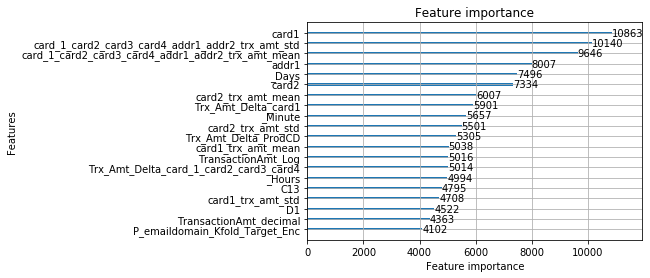

In [11]:
lgb.plot_importance(estimator,max_num_features =20)

In [12]:
X_valid.shape

(89326, 508)

In [14]:
X_train.shape

(501214, 508)

In [13]:
X_test.shape

(506691, 508)

In [ ]:
Y_pred = estimator.predict(X_test)

In [23]:
Y_pred = estimator.predict(X_test)
submission = pd.DataFrame({
    "TransactionID": test_id_to_be_used, 
    "isFraud": Y_pred
})
submission.to_csv('lgb_submission 10.csv', index=False)